# TECHSAS geolocation notebook

### This notebook provides methods to apply navigation on TECHSAS files.

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
%matplotlib inline

### Methods

In [33]:
def read_nvi(file_path):
    """Read a nvi file and return dataset indexed by time"""
    with xr.open_dataset(file_path) as ds:
        # get date as EPOCH
        datetime = pd.to_datetime((ds['mbDate'].data - 2440588) * 24 * 3600 * 1000 + ds['mbTime'].data, unit='ms')
        # return new dataset with only needed variables
        return xr.Dataset(
             data_vars = {
                "lon": (["time"], ds['mbAbscissa'].data, ds['mbAbscissa'].attrs),
                "lat": (["time"], ds['mbOrdinate'].data, ds['mbOrdinate'].attrs),
                "heading": (["time"], ds['mbHeading'].data,  ds['mbHeading'].attrs),
                "speed": (["time"], ds['mbSpeed'].data, ds['mbSpeed'].attrs),
                "altitude": (["time"], ds['mbAltitude'].data, ds['mbAltitude'].attrs)
             },
            coords = {
                "time" : datetime
            })

<xarray.Dataset>
Dimensions:   (time: 1464952)
Coordinates:
  * time      (time) datetime64[ns] 2014-03-15T20:46:31 ... 2014-04-01T19:46:08
Data variables:
    lon       (time) float64 -61.55 -61.55 -61.55 ... -35.72 -35.72 -35.72
    lat       (time) float64 16.23 16.23 16.23 16.23 ... -9.68 -9.68 -9.68 -9.68
    heading   (time) float64 nan 180.0 180.0 180.0 ... 116.9 180.0 180.0 180.0
    speed     (time) float32 nan 0.0 0.0 0.0 0.0 0.0 ... 0.02 0.05 0.02 0.0 0.04
    altitude  (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [23]:
def apply_navigation(techsas_file_path : str, nvi_file_path : str):
    """Read an NVI and a TECHSAS file and return an TECHSAS dataset with navigation"""
    nvi_ds = read_nvi(nvi_file_path)
    with xr.open_dataset(techsas_file_path) as techsas_ds:
        # use 'unwrap' method to get a correct interpolation of heading
        heading_unwrapped = nvi_ds['heading']
        heading_unwrapped[~np.isnan(heading_unwrapped)] = np.unwrap(
            heading_unwrapped[~np.isnan(heading_unwrapped)], period=360)
        nvi_ds['heading'] = heading_unwrapped
        # interpolation
        interp_nvi_ds = nvi_ds.interp_like(techsas_ds)
        # apply modulo on heading (because heading has been unwraped before interpolation)
        interp_nvi_ds['heading'] = interp_nvi_ds['heading'] % 360
        # merge gravi & interpolated navigation
        return techsas_ds.merge(interp_nvi_ds)

---
### Test

In [25]:
base_path = "C://Users//gbillant//Desktop//test_gravi//2014000700//"
gravi_file = base_path + "201400070045-KSS-AT_KSS31M.gravi"
mag_file = base_path + "201400070045-scalar_mag-AT_MAGSS.mag"
nvi_file = base_path + "201400070055.nvi"
output_file = base_path + "201400070055.mgd77"

In [24]:
base_path = "C://Users//gbillant//Desktop//test_gravi//Salsa-leg1-14000800//tests//"
gravi_file_test = base_path + "201400080045-KSS-AT_KSS31M.gravi"
nvi_file_test = base_path + "201400080055.nvi"
ds = apply_navigation(gravi_file_test, nvi_file_test).to_netcdf(gravi_file_test.replace('.gravi','.gravi.nc'))

In [26]:
# get gravi dataset with navigation
gravi_nav_ds = apply_navigation(gravi_file, nvi_file)
gravi_nav_ds.to_netcdf(gravi_file.replace('.gravi','.gravi.nc'))

In [7]:
# get mag dataset with navigation
mag_nav_ds = apply_navigation(mag_file, nvi_file, )
mag_nav_ds.to_netcdf(mag_file.replace('.mag','.mag.nc'))

In [8]:
gravi_nav_ds_resampled = gravi_nav_ds.resample(time='60S',  closed='left').nearest(tolerance='2S')
gravi_nav_ds_resampled.to_netcdf(base_path+'gravi_nav_resampled.gravi.nc')

In [15]:
gravi_nav_ds['time']

<xarray.DataArray 'time' (time: 24213)>
array(['2014-03-17T20:50:11.516639744', '2014-03-17T20:50:14.517312000',
       '2014-03-17T20:50:17.517120000', ..., '2014-03-24T10:59:20.815583744',
       '2014-03-24T10:59:23.817120256', '2014-03-24T10:59:26.816927744'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-03-17T20:50:11.516639744 ... 2014-03-...
Attributes:
    long_name:  acquisition time
    axis:       T

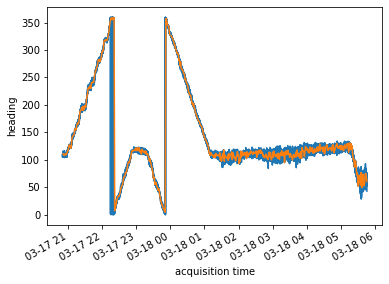

In [25]:
start = "2014-03-17 12"
end = "2014-03-19 13"
gravi_nav_ds['heading'].loc[start:end].plot()
gravi_nav_ds_resampled['heading'].loc[start:end].plot()

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

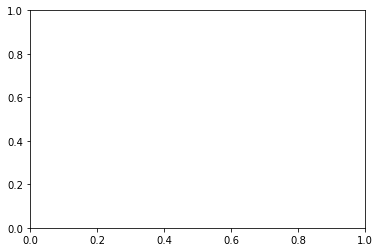

In [9]:
gravi_nav_ds['heading'].loc["2014-04-17 02:56:05":"2014-04-17 02:56:40"].plot.line(".")

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

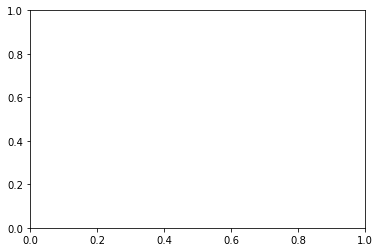

In [10]:
gravi_nav_ds['heading'].loc["2014-04-17 12:00":"2014-04-17 12:30"].plot()
gravi_nav_ds_resampled['heading'].loc["2014-04-17 12:00":"2014-04-17 12:30"].plot()

In [161]:
gravi_nav_ds_resampled = gravi_nav_ds.resample(time='60S',  closed='left').nearest(tolerance='2S')

In [163]:
gravi_nav_ds_resampled.to_netcdf(base_path+'test_17h22.gravi.nc')

In [76]:
gravi_ds.resample(time='60S',  closed='left').nearest(tolerance='2S')

<xarray.Dataset>
Dimensions:   (time: 41101)
Coordinates:
  * time      (time) datetime64[ns] 2014-04-04T22:00:00 ... 2014-05-03T11:00:00
Data variables:
    datation  (time) float32 nan 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    bouguer   (time) float32 nan -490.6 -491.0 -491.5 ... -73.4 -73.4 -73.2
    seastate  (time) float32 nan 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 2.0
    freeair   (time) float32 nan -491.4 -491.5 -491.7 ... -434.1 -434.2 -433.9
    acY       (time) float32 nan 0.0011 -0.0012 -0.0014 ... 0.0032 -0.0009 0.0
    acX       (time) float32 nan 0.0008 0.0006 0.0051 ... 0.0002 0.0009 -0.0008
    eoetvoes  (time) float32 nan -2.979e+03 -2.979e+03 ... -2.807e+03 -2.807e+03
    gravity   (time) float32 nan -2.979e+03 -2.979e+03 ... -2.807e+03 -2.807e+03
Attributes: (12/25)
    history:                       Tue Jul 22 14:46:51 2014: /home/coriolis_e...
    source:                        Acquisition of KSS31M
    conventions:                   CF-1.0.
    creationtime:                  2014-04-04T22:00:41Z
    device_firstusedate:           2000-01-01T00:00:00Z
    device_deviceid:               AT_KSS31M_01
    ...                            ...
    frame_sourcetype:              gravi
    frame_period:                  1.0
    title:                         Technical and Scientific sensors Acquisiti...
    institution:                   IFR
    reference:                     http://www.ifremer.fr
    nco_openmp_thread_number:      1

In [6]:
df = pd.read_table('C://Users//gbillant//Desktop//GLOBE_MAINTENANCE//2022-05-20//2021-09-17--2022-03-28//sea042.merge_adj.pld1_gb.all.txt')

C:\dev\miniconda\envs\pyat_dev\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (3,4,10,11,12,13,14,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
df_cut = df[:10000]

In [8]:
df[:10000].to_csv('C://Users//gbillant//Desktop//GLOBE_MAINTENANCE//2022-05-20//2021-09-17--2022-03-28//sea042.merge_adj.pld1_gb_cut.all.txt')